In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import talib

plt.style.use('ggplot')

# 資料載入

In [3]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [4]:
settlementDate_ = pd.read_csv('settlementDate.csv', encoding = 'big5')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/8/31,202208W5,15078
1,2022/8/24,202208W4,15097
2,2022/8/17,202208,15452
3,2022/8/10,202208W2,14945
4,2022/8/3,202208W1,14707
...,...,...,...
512,2009/12/16,200912,7752
513,2009/11/18,200911,7786
514,2009/10/21,200910,7705
515,2009/9/16,200909,7445


In [5]:
ftr = pd.read_csv('foi&pc_ratio.csv')
ftr.index = pd.to_datetime(ftr.Date)
ftr = ftr.drop(columns = ['Date'])
ftr

,外資未平倉,PC ratio
Date,,
2007-07-02,-6558,94.00
2007-07-03,-7244,99.37
2007-07-04,-10093,107.74
2007-07-05,-11282,112.52
2007-07-06,-11925,115.57
...,...,...
2022-06-06,8528,105.68
2022-06-07,6617,99.09
2022-06-08,9587,107.31


# 資料處裡

日k整理

In [6]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [7]:
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [8]:
Morning=Morning.drop(columns=['Hour'])
daily = Morning.resample("B").agg(dict(zip(Morning.columns,["first", "max", "min", "last", "sum"])))
daily = daily[daily["close"].isna()==False].copy()
daily

,open,high,low,close,volume
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382
...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478


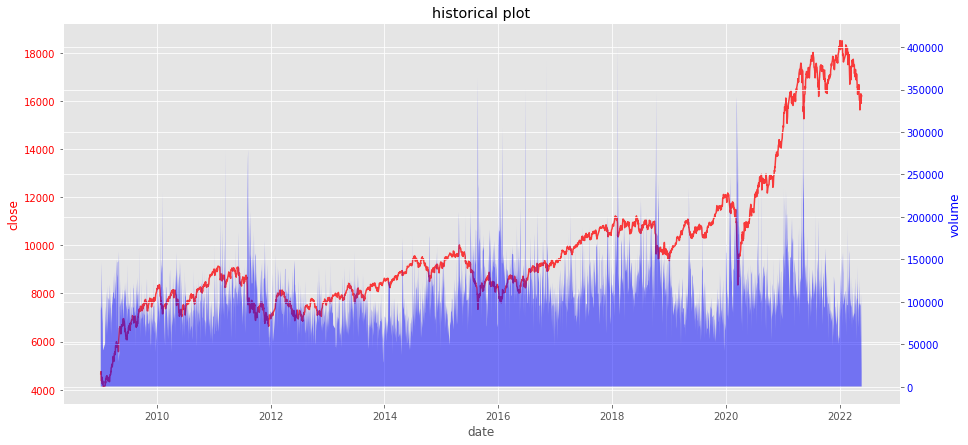

In [9]:
fig, ax1 = plt.subplots(figsize = (15,7))
plt.title('historical plot')
plt.xlabel('date')
ax2 = ax1.twinx()
ax1.set_ylabel('close', color='red')
ax1.plot(daily.close, color='red', alpha=0.75)
ax1.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('volume', color='blue')
ax2.fill_between(daily.index, daily.volume, 100, facecolor  = 'blue', label = 'volume', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='blue')

In [10]:
daily = pd.concat([daily, ftr], axis = 1, join = 'inner').dropna()
daily = daily.rename(columns = dict(zip(daily.columns, ['Open', 'High', 'Low', 'Close', 'Volume','Foreign_OI','PC_ratio']))) 
daily

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869,11435,66.79
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227,12294,68.42
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777,14821,70.11
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219,15009,64.57
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382,18302,64.13
...,...,...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


In [11]:
trainData = daily[(daily.index >= '2011-01-01 00:00:00') & (daily.index <= '2019-12-31 00:00:00')].copy()
testData = daily[(daily.index >= '2020-1-1 00:00:00') & (daily.index <= '2022-5-22 00:00:00')].copy()

In [12]:
trainData.head(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365,-12611,128.13
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448,-14207,126.30
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831,-15303,117.69
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510,-15135,114.87
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752,-11883,113.53


In [13]:
testData.tail(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948,-2540,89.74
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


結算日

In [14]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
settlementDate[-5:]

[datetime.date(2009, 12, 16),
 datetime.date(2009, 11, 18),
 datetime.date(2009, 10, 21),
 datetime.date(2009, 9, 16),
 datetime.date(2009, 8, 19)]

# 回測

In [59]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02

In [60]:
trainData['plus'] = talib.PLUS_DI(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=14)
trainData['minus'] = talib.MINUS_DI(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=14)
trainData['ADX'] = talib.ADX(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=14)

In [61]:
trainData.head(20)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio,plus,minus,ADX
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365,-12611,128.13,NaN,NaN,NaN
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448,-14207,126.30,NaN,NaN,NaN
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831,-15303,117.69,NaN,NaN,NaN
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510,-15135,114.87,NaN,NaN,NaN
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752,-11883,113.53,NaN,NaN,NaN
2011-01-10,8753.0,8799.0,8735.0,8787.0,68285,-9186,113.55,NaN,NaN,NaN
2011-01-11,8779.0,8950.0,8760.0,8941.0,131177,-7542,116.19,NaN,NaN,NaN
2011-01-12,8960.0,9003.0,8945.0,8967.0,82510,-11930,119.64,NaN,NaN,NaN
2011-01-13,8998.0,9017.0,8916.0,8969.0,107227,-12340,122.77,NaN,NaN,NaN
2011-01-14,8965.0,8981.0,8931.0,8970.0,67139,-12655,122.21,NaN,NaN,NaN


In [62]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

             profit  profitfee
2011-01-03      0.0        0.0
2011-01-04      0.0        0.0
2011-01-05      0.0        0.0
2011-01-06      0.0        0.0
2011-01-07      0.0        0.0
...             ...        ...
2019-12-25   1000.0   -84200.0
2019-12-26   9000.0   -76200.0
2019-12-27  10800.0   -74400.0
2019-12-30  21400.0   -63800.0
2019-12-31   9000.0   -77400.0

[2197 rows x 2 columns]


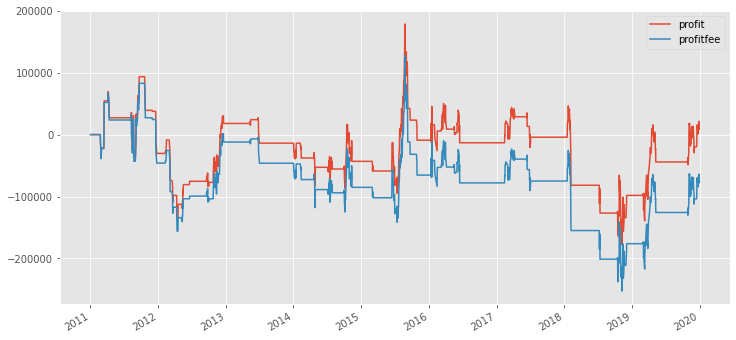

In [66]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = (df_arr[i,7] > df_arr[i,8]) & (df_arr[i,6] >= 110) & (df_arr[i,-1] > 25)
    entrySellShort = (df_arr[i,7] < df_arr[i,8]) & (df_arr[i,6] <= 90) & (df_arr[i,-1] > 25)
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場
    exitShort = ((df_arr[i,7] <= df_arr[i,8]) & (df_arr[i,6] <= l)) or (df_arr[i,-1] <= 25)
    exitBuyToCover = ((df_arr[i,7] >= df_arr[i,8]) & (df_arr[i,6] >= h)) or (df_arr[i,-1] <= 25)
    exitCondition = date_arr[i] in settlementDate  ####
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [67]:
print(buy)
print(sell)
print(sellshort)
print(buytocover)

[59, 268, 282, 291, 356, 420, 423, 469, 483, 574, 735, 806, 857, 867, 941, 1016, 1156, 1179, 1247, 1264, 1273, 1317, 1323, 1490, 1494, 1512, 1568, 1579, 1721, 1723, 1934, 1988, 2003, 2021, 2150, 2169, 2185, 2189]
[63, 273, 285, 295, 357, 422, 430, 482, 486, 578, 746, 812, 866, 874, 948, 1021, 1158, 1182, 1251, 1272, 1284, 1318, 1332, 1493, 1511, 1527, 1571, 1584, 1722, 1736, 1936, 2002, 2020, 2035, 2168, 2177, 2188, 2196]
[32, 43, 146, 151, 153, 162, 167, 172, 196, 225, 237, 241, 308, 312, 328, 446, 604, 756, 918, 930, 1088, 1092, 1097, 1106, 1110, 1118, 1135, 1138, 1141, 1234, 1312, 1832, 1900, 1907]
[35, 46, 150, 152, 156, 166, 171, 176, 198, 226, 240, 242, 311, 314, 333, 466, 609, 759, 928, 937, 1091, 1096, 1101, 1109, 1117, 1133, 1137, 1140, 1149, 1240, 1314, 1836, 1903, 1928]


In [68]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

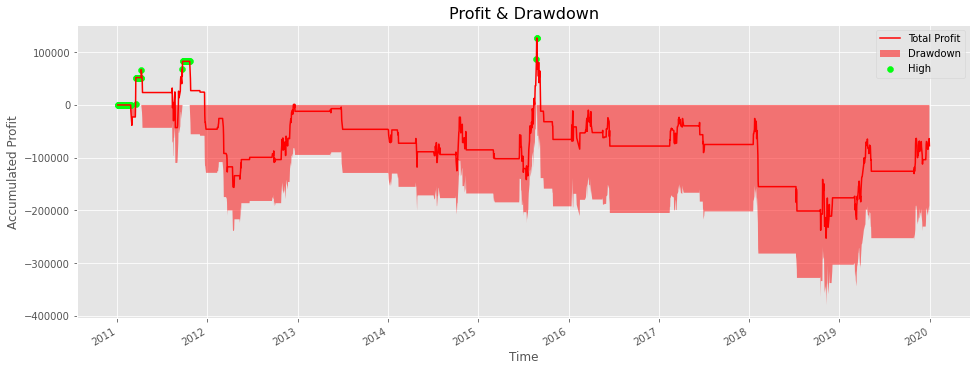

In [69]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

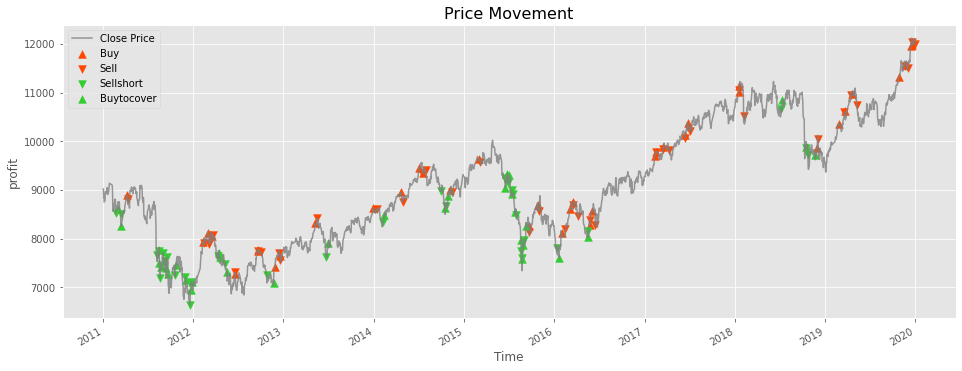

In [70]:
fig, ax = plt.subplots(figsize = (16,6))

trainData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(trainData['Close'].iloc[buy].index, trainData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(trainData['Close'].iloc[sell].index, trainData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[sellshort].index, trainData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[buytocover].index, trainData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [71]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $-77400.0
return: -7.739999999999999%
mdd: 33.7%
calmarRatio: -0.23
tradeTimes: 72
winRate: 43.059999999999995%
profitFactor: 0.94
winLossRatio: 1.24


# 最佳化

In [72]:
optimizationList = []

fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
rule = '1D'

for f in range(7,15,1):
    for s in range(20, 31, 1):
        for h in range(105,140,5):
            for l in range(65,100,5):
                print('----------')
                print(f'dmi_window: {f}')
                print(f'adx臨界值: {s}')
                print(f'pc_ratio high: {h}')
                print(f'pc_ratio low: {l}')
                data = trainData.iloc[:,:7].copy()
                
                data['plus'] = talib.PLUS_DI(data['High'], data['Low'], data['Close'], timeperiod=f)
                data['minus'] = talib.MINUS_DI(data['High'], data['Low'], data['Close'], timeperiod=f)
                data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=f)

                time_arr = np.array(data.index)
                df_arr = np.array(data)
        

                BS = None
                buy = []
                sell = []
                sellshort = []
                buytocover = []
                profit_list = [0]
                profit_fee_list = [0]
                profit_fee_list_realized = []

                for i in range(len(df_arr)):
                    if i == len(df_arr)-1:
                        break
        
                ## 進場邏輯
                    entryLong = (df_arr[i,7] > df_arr[i,8]) & (df_arr[i,6] >= h) & (df_arr[i,-1] > s)
                    entrySellShort = (df_arr[i,7] < df_arr[i,8]) & (df_arr[i,6] <= l) & (df_arr[i,-1] > s)
                    entryCondition = date_arr[i] not in settlementDate
    
                ## 出場邏輯
                    exitShort = ((df_arr[i,7] >= df_arr[i,8]) & (df_arr[i,6] >= h)) or (df_arr[i,-1] <= s)
                    exitBuyToCover = ((df_arr[i,7] >= df_arr[i,8]) & (df_arr[i,6] >= h)) or (df_arr[i,-1] <= s)
                    exitCondition = date_arr[i] in settlementDate
    
                ## 停利停損邏輯
                    if BS == 'B':
                        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
                        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
                    elif BS == 'S':
                        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
                        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

                    if BS == None:
                        profit_list.append(0)
                        profit_fee_list.append(0)
         
                        if entryLong and entryCondition:
                            BS = 'B'
                            t = i+1
                            buy.append(t)

                        elif entrySellShort and entryCondition:
                            BS = 'S'
                            t = i+1
                            sellshort.append(t)
            
                    elif BS == 'B':
                        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
                        profit_list.append(profit)
            
                        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
                            profit_fee = profit - feePaid*2
                            profit_fee_list.append(profit_fee)
                            sell.append(i+1)
                            BS=None
            
                            # Realized PnL
                            profit_fee_realized = pl_round - feePaid*2
                            profit_fee_list_realized.append(profit_fee_realized)
             
                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
            
                    elif BS == 'S': 
                        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
                        profit_list.append(profit)
        
                        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
                            profit_fee = profit - feePaid*2
                            profit_fee_list.append(profit_fee)
                            buytocover.append(i+1)
                            BS=None
            
                            # Realized PnL
                            profit_fee_realized = pl_round - feePaid*2
                            profit_fee_list_realized.append(profit_fee_realized)
 
                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
     
                equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=data.index)
                equity['equity'] = equity['profitfee'] + fund
                equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
                equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
                ret = equity['equity'][-1]/equity['equity'][0] - 1
                mdd = abs(equity['drawdown_percent'].min())
                calmarRatio = ret / mdd
                   
                optimizationList.append([f, s, h, l, ret, calmarRatio])###

----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 20
pc_ratio high: 110
pc_ratio 

----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 22
pc_ratio high: 125
pc_ratio 

----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 24
pc_ratio high: 135
pc_ratio 

----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 27
pc_ratio high: 115
pc_ratio 

----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 7
adx臨界值: 29
pc_ratio high: 125
pc_ratio 

----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 20
pc_ratio high: 135
pc_ratio 

----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 23
pc_ratio high: 115
pc_ratio 

----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 25
pc_ratio high: 125
pc_ratio 

----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 28
pc_ratio high: 105
pc_ratio 

----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 8
adx臨界值: 30
pc_ratio high: 120
pc_ratio 

----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 21
pc_ratio high: 130
pc_ratio 

----------
dmi_window: 9
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 24
pc_ratio high: 110
pc_ratio 

----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 26
pc_ratio high: 120
pc_ratio 

----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 9
adx臨界值: 28
pc_ratio high: 135
pc_ratio 

----------
dmi_window: 9
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 9
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 9
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 9
adx臨界值: 30
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 20
pc_ratio high: 110

----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 22
pc_ratio high:

----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 24
pc_ratio high:

----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 27
pc_ratio high:

----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 10
adx臨界值: 29
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 20
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 23
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 25
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 27
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 28
pc_ratio high:

----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 11
adx臨界值: 30
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 21
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 23
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 24
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 24
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 26
pc_ratio high:

----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 12
adx臨界值: 28
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 20
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 22
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 24
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 25
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 25
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 27
pc_ratio high:

----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 13
adx臨界值: 29
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 20
pc_ratio high: 135
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 105
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 105
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 105
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 21
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 23
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 125
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 130
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high: 135
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 25
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 105
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 110
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 110
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 110
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 110
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 110
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 110
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 110
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 115
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high: 115
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 28
pc_ratio high:

----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 115
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 85
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 90
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 120
pc_ratio low: 95
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 65
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 70
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 75
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high: 125
pc_ratio low: 80
----------
dmi_window: 14
adx臨界值: 30
pc_ratio high:

In [73]:
len(optimizationList)

4312

In [74]:
optimizationList = pd.DataFrame(optimizationList, columns=['window', 'adx','high','low','ret','calmarRatio'])
optimizationList

,window,adx,high,low,ret,calmarRatio
0,7,20,105,65,-0.4694,-0.788422
1,7,20,105,70,-0.2180,-0.580010
2,7,20,105,75,-0.1160,-0.298951
3,7,20,105,80,-0.0942,-0.300108
4,7,20,105,85,-0.2204,-0.514658
...,...,...,...,...,...,...
4307,14,30,135,75,0.1708,1.639028
4308,14,30,135,80,0.0438,0.283414
4309,14,30,135,85,-0.0682,-0.286881
4310,14,30,135,90,0.0310,0.143223


In [75]:
optimizationList.sort_values('ret', ascending=False).iloc[:5]

,window,adx,high,low,ret,calmarRatio
579,8,20,130,90,0.7236,5.793190
586,8,20,135,90,0.7204,6.450333
572,8,20,125,90,0.6830,3.814782
621,8,21,125,90,0.6736,3.587652
628,8,21,130,90,0.6444,5.763686


In [76]:
optimizationList.sort_values('calmarRatio', ascending=False).iloc[:5]

,window,adx,high,low,ret,calmarRatio
586,8,20,135,90,0.7204,6.450333
579,8,20,130,90,0.7236,5.793190
628,8,21,130,90,0.6444,5.763686
635,8,21,135,90,0.6406,5.202530
1465,9,27,135,75,0.5540,5.085685


In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\User\AppData\Local\Temp\ipykernel_10856\1555837335.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


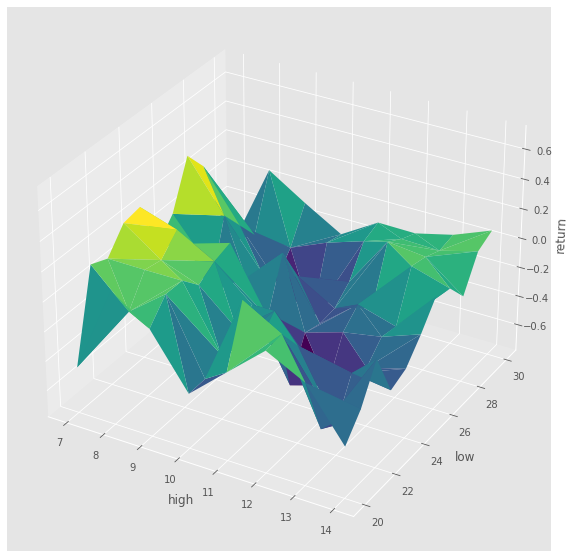

In [78]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.window, optimizationList.adx, optimizationList.ret, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_10856\2934912639.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


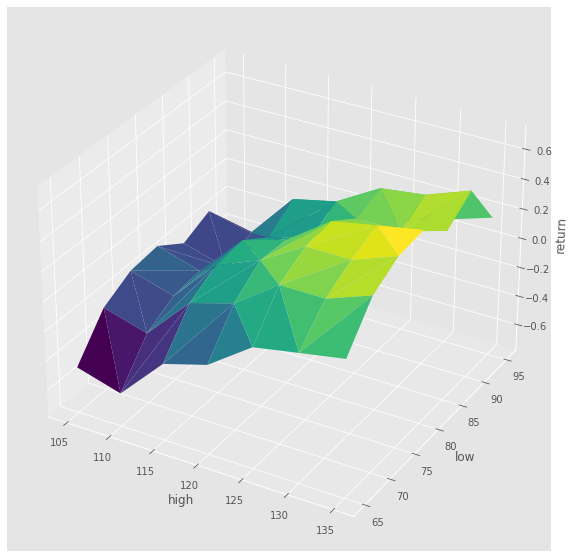

In [79]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.high, optimizationList.low, optimizationList.ret, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_10856\2195552037.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


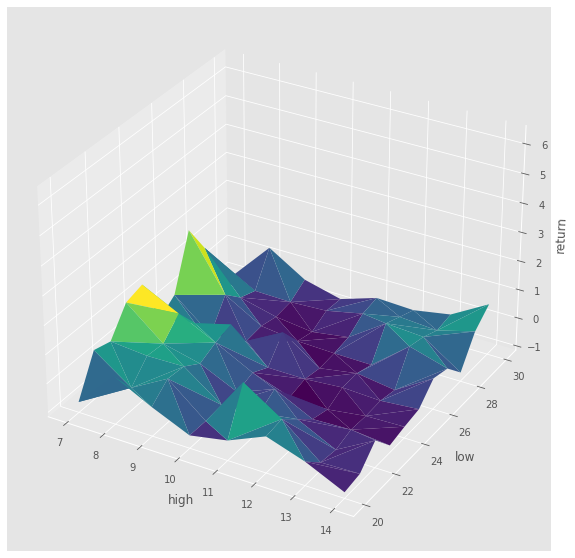

In [80]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.window, optimizationList.adx, optimizationList.calmarRatio, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_10856\2961654477.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


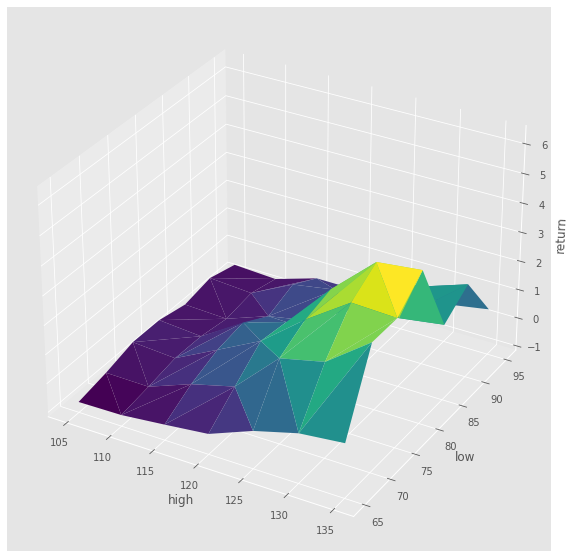

In [81]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.high, optimizationList.low, optimizationList.calmarRatio, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

# 樣本外測試

In [83]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
testData['plus'] = talib.PLUS_DI(testData['High'], testData['Low'], testData['Close'], timeperiod=8)
testData['minus'] = talib.MINUS_DI(testData['High'], testData['Low'], testData['Close'], timeperiod=8)
trainData['ADX'] = talib.ADX(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=8)
df_arr = np.array(testData)
time_arr = np.array(testData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

              profit  profitfee
2020-01-02       0.0        0.0
2020-01-03       0.0        0.0
2020-01-06       0.0        0.0
2020-01-07       0.0        0.0
2020-01-08       0.0        0.0
...              ...        ...
2022-05-16  202800.0   171600.0
2022-05-17  206400.0   175200.0
2022-05-18  166000.0   134800.0
2022-05-19  227800.0   195400.0
2022-05-20  227800.0   195400.0

[578 rows x 2 columns]


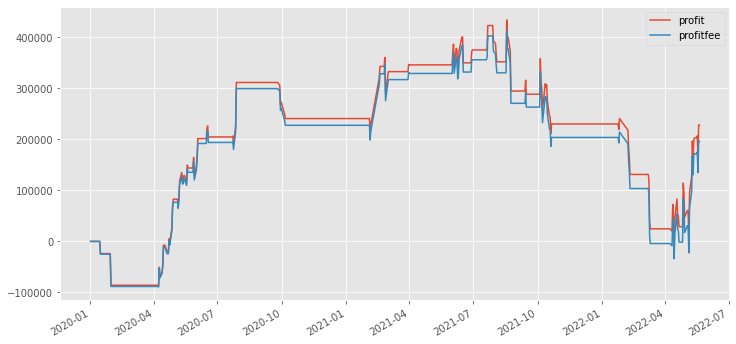

In [91]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = (df_arr[i,7] > df_arr[i,8]) & (df_arr[i,6] >= 135) & (df_arr[i,-1] > 20)
    entrySellShort = (df_arr[i,7] < df_arr[i,8]) & (df_arr[i,6] <= 90) & (df_arr[i,-1] > 20)
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = ((df_arr[i,7] <= df_arr[i,8]) & (df_arr[i,6] <= 90)) or df_arr[i,-1]<=20
    exitBuyToCover = (df_arr[i,7] >= df_arr[i,8]) & (df_arr[i,6] >= 135) or df_arr[i,-1]<=20
    exitCondition = date_arr[i] in settlementDate  ####
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=testData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [92]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

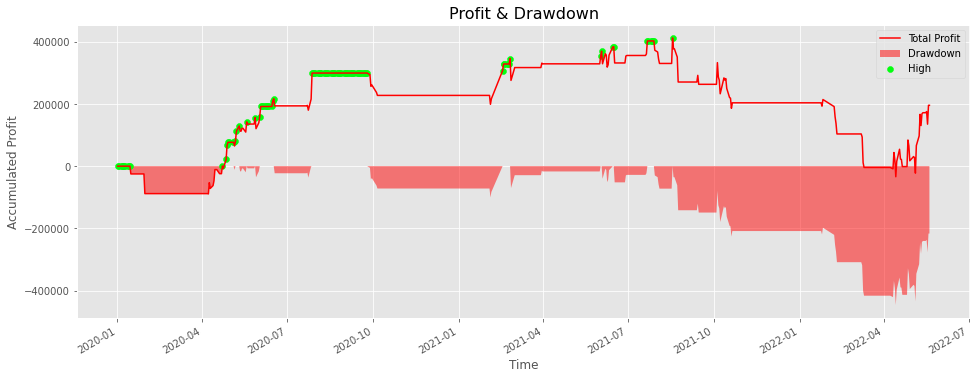

In [93]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

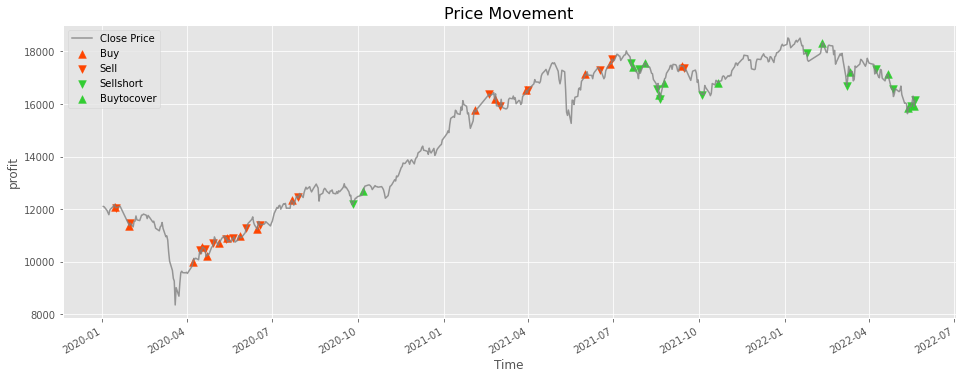

In [94]:
fig, ax = plt.subplots(figsize = (16,6))

testData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(testData['Close'].iloc[buy].index, testData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(testData['Close'].iloc[sell].index, testData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(testData['Close'].iloc[sellshort].index, testData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(testData['Close'].iloc[buytocover].index, testData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [95]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $195400.0
return: 19.54%
mdd: 31.580000000000002%
calmarRatio: 0.62
tradeTimes: 28
winRate: 59.260000000000005%
profitFactor: 1.31
winLossRatio: 0.9
